In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_curve, auc
from sklearn.metrics import f1_score as sk_f1_score
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import pickle
from collections import Counter
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

In [2]:
data_dir = 'u_net_data'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
pickle_dir = os.path.join(data_dir, 'mask_pickle')

In [3]:
img_height, img_width = 512, 512

In [4]:
first_n = 300
image_list = os.listdir(image_dir)
if '.ipynb_checkpoints' in image_list:
    image_list.remove('.ipynb_checkpoints')
    image_list = image_list#[:first_n]
mask_list = os.listdir(mask_dir)#[:first_n]
pickle_list = os.listdir(pickle_dir)#[:first_n]
print(f'number of samples {len(image_list)}')
print(f'number of samples {len(pickle_list)}')

number of samples 1342
number of samples 1342


In [5]:
X = np.zeros((len(image_list), img_height, img_width, 3), dtype=np.float32)
y = np.zeros((len(mask_list), img_height, img_width, 1), dtype=np.float32)
remove = []
for i, (image, mask) in tqdm(enumerate(zip(image_list, mask_list))):
    try:
        pickle_name = os.path.join(pickle_dir, mask.split('.')[0] + '.pickle')
        with open(pickle_name, "rb") as file:
            mask = pickle.load(file)
        if (np.sum(mask)/255 < 1000) or (np.sum(mask)/255 > 10000) or len(np.unique(mask)) != 2:
            remove.append(i)
        if len(np.unique(mask)) != 2:
            remove.append(i)
        y[i] = mask.reshape(img_height, img_width, 1)/255
        img = imread(os.path.join(image_dir, image))
        X[i] = img / 255
    except:
        remove.append(i)
        continue
        
X = np.delete(X, remove, axis=0)
y = np.delete(y, remove, axis=0)
y = y.astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

1342it [01:02, 21.39it/s]


In [6]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("\nShape of all data:", X.shape)

Shape of X_train: (768, 512, 512, 3)
Shape of X_val: (86, 512, 512, 3)
Shape of y_train: (768, 512, 512, 1)
Shape of y_val: (86, 512, 512, 1)

Shape of all data: (854, 512, 512, 3)


In [7]:
min_value = np.min(X)
max_value = np.max(X)

print("minimum pixel value:", min_value)
print("maximum pixel value:", max_value)

minimum pixel value: 0.0
maximum pixel value: 1.0


In [8]:
print(f"unique values of y: {np.unique(y)}")

unique values of y: [0 1]


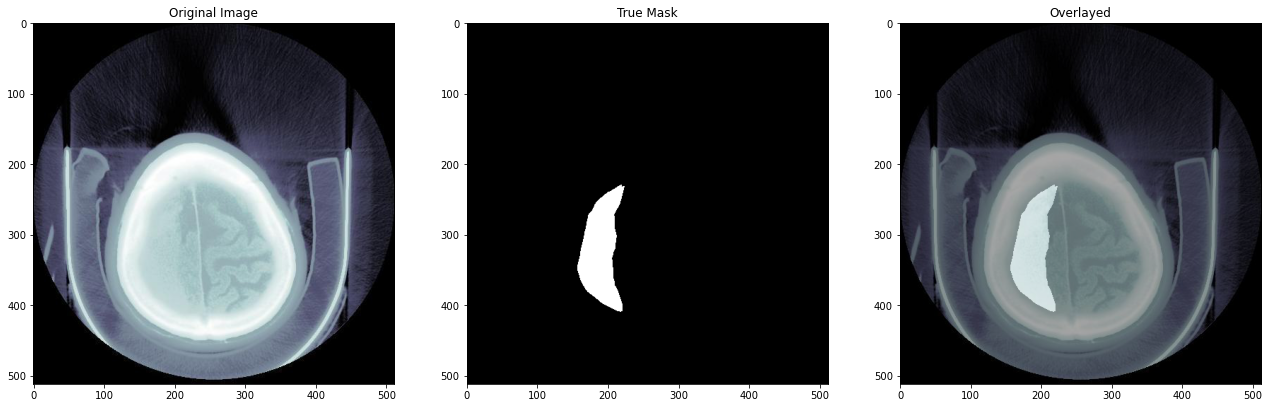

In [9]:
# 0 black, 1 white

index = np.random.randint(len(X_train))
image = X_train[index]
true_mask = y_train[index]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

axes[0].imshow(image)
axes[0].set_title("Original Image")

axes[1].imshow(true_mask.squeeze(), cmap='gray')
axes[1].set_title("True Mask")

axes[2].imshow(image)
axes[2].imshow(true_mask.squeeze(), cmap='gray', alpha=0.35)
axes[2].set_title("Overlayed")

plt.show()

In [10]:
def conv_block(inputs, filters, bn = True):
    conv = Conv2D(filters, (3, 3), padding='same')(inputs)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(filters, (3, 3), padding='same')(conv)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

def unet(input_size=(img_height, img_width, 3), num_filters=8):
    inputs = Input(input_size)

    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, num_filters*2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, num_filters*4)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, num_filters*8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, num_filters*16)

    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, num_filters*8)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, num_filters*4)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, num_filters*2)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, num_filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=inputs, outputs=outputs)

In [11]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [50]:
def iou(y_true, y_pred, threshold = 0.25):
    y_true = K.cast(K.greater(y_true, threshold), dtype='float32')
    y_pred = K.cast(K.greater(y_pred, threshold), dtype='float32')

    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection

    return K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)

def find_optimal_threshold_f1(y_true, y_pred_probs, thresholds):
    best_threshold = 0
    best_f1 = 0
    
    for threshold in tqdm(thresholds):
        y_pred = (y_pred_probs > threshold).astype(np.uint8)
        f1 = sk_f1_score(y_true.ravel(), y_pred.ravel())
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    return best_threshold

def f1_score(y_true, y_pred, threshold=0.25):
    y_true_bin = tf.cast(y_true > threshold, dtype=tf.float32)
    y_pred_bin = tf.cast(y_pred > threshold, dtype=tf.float32)
    
    tp = tf.reduce_sum(y_true_bin * y_pred_bin)
    fp = tf.reduce_sum((1 - y_true_bin) * y_pred_bin)
    fn = tf.reduce_sum(y_true_bin * (1 - y_pred_bin))
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    
    return f1

def accuracy(y_true, y_pred, threshold=0.25):
    y_true_bin = tf.cast(y_true > threshold, dtype=tf.float32)
    y_pred_bin = tf.cast(y_pred > threshold, dtype=tf.float32)

    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true_bin, y_pred_bin), dtype=tf.float32))
    total_predictions = tf.cast(tf.reduce_prod(tf.shape(y_true_bin)), dtype=tf.float32)

    return correct_predictions / total_predictions


def evaluate_segmentation(X_val, y_val, model, thresholds=np.linspace(0.1, 0.9, 9)):
    y_pred_probs = model.predict(X_val)

    best_threshold = find_optimal_threshold_f1(y_val, y_pred_probs, thresholds)
    
    y_pred = (y_pred_probs > best_threshold).astype(np.uint8)

    final_iou = iou(y_val, y_pred, threshold = best_threshold).numpy()
    final_f1 = f1_score(y_val, y_pred, threshold=best_threshold).numpy()
    final_accuracy = accuracy(y_val, y_pred, threshold=best_threshold).numpy()

    print(f'Best threshold: {best_threshold:.3f}')
    print(f'IOU: {final_iou:.3f}')
    print(f'F1 Score: {final_f1:.3f}')
    print(f'Accuracy: {final_accuracy:.3f}')

In [13]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', f1_score, iou])

checkpoint = ModelCheckpoint('unet_weights.h5', monitor='val_loss', save_best_only=True)

epochs = 50
batch_size = 6

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=(X_val, y_val))

Epoch 1/50
128/128 [==============================] - 40s 312ms/step - loss: 0.4430 - accuracy: 0.9656 - f1_score: 0.0236 - iou: 0.0119 - val_loss: 0.5273 - val_accuracy: 0.9869 - val_f1_score: 0.0257 - val_iou: 0.0130
Epoch 2/50
128/128 [==============================] - 39s 301ms/step - loss: 0.3726 - accuracy: 0.9886 - f1_score: 0.0239 - iou: 0.0121 - val_loss: 0.4062 - val_accuracy: 0.9800 - val_f1_score: 0.0257 - val_iou: 0.0130
Epoch 3/50
128/128 [==============================] - 39s 303ms/step - loss: 0.3387 - accuracy: 0.9898 - f1_score: 0.0283 - iou: 0.0144 - val_loss: 0.3472 - val_accuracy: 0.9896 - val_f1_score: 0.0265 - val_iou: 0.0134
Epoch 4/50
128/128 [==============================] - 39s 302ms/step - loss: 0.3151 - accuracy: 0.9899 - f1_score: 0.0383 - iou: 0.0199 - val_loss: 0.3139 - val_accuracy: 0.9885 - val_f1_score: 0.0374 - val_iou: 0.0191
Epoch 5/50
128/128 [==============================] - 39s 302ms/step - loss: 0.2940 - accuracy: 0.9902 - f1_score: 0.0473 - 

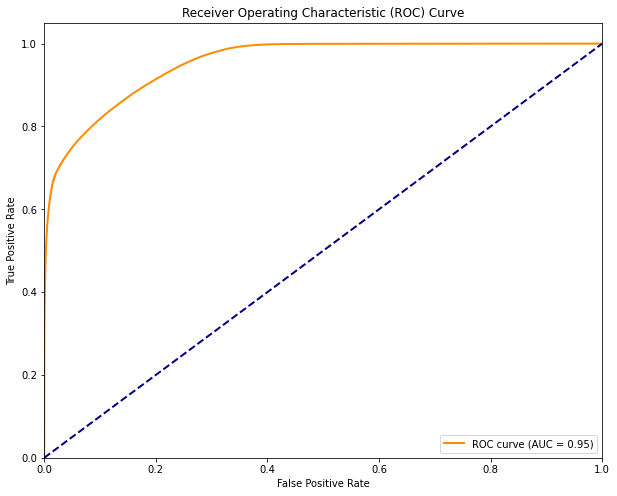

In [14]:
y_pred = model.predict(X_val)
y_pred = y_pred.ravel()
y_vals = y_val.ravel()

fpr, tpr, thresholds = roc_curve(y_vals, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
evaluate_segmentation(X_val, y_val, model, thresholds=np.linspace(0, 1, 50))

100%|██████████| 50/50 [05:37<00:00,  6.74s/it]


Best threshold: 0.245
IOU: 0.401
F1 Score: 0.577
Accuracy: 0.990


44


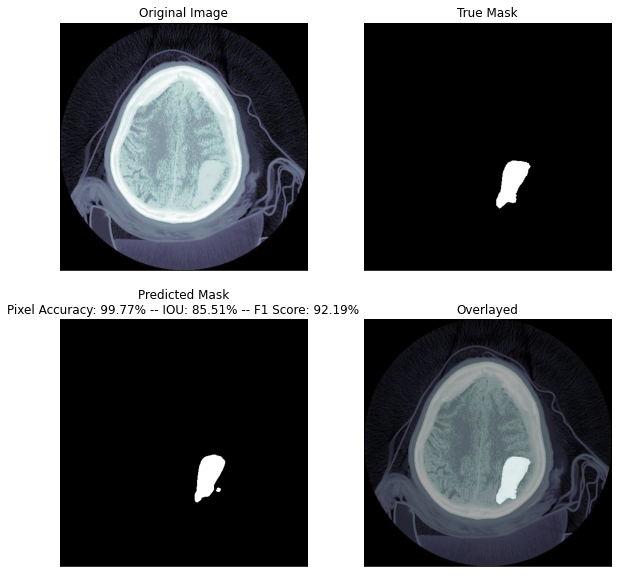

In [42]:
index = np.random.randint(len(X_val))
print(index)
# index = 60
image = X_val[index]
true_mask = np.where(np.abs(y_val[index]), 1, 0)
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
predicted_mask = (predicted_mask > 0.2105).astype(np.uint8)
pixel_accuracy = (predicted_mask == true_mask).mean()

intersection = np.logical_and(predicted_mask, true_mask).sum()
union = np.logical_or(predicted_mask, true_mask).sum()
iou = intersection / (union + 1e-7) * 100

cm = confusion_matrix(true_mask.flatten(), predicted_mask.flatten())
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
f1 = 2 * precision * recall / (precision + recall)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")

axes[0, 1].imshow(true_mask.squeeze(), cmap='gray')
axes[0, 1].set_title("True Mask")

axes[1, 0].imshow(predicted_mask.squeeze(), cmap='gray')
axes[1, 0].set_title("Predicted Mask\nPixel Accuracy: {:.2f}% -- IOU: {:.2f}% -- F1 Score: {:.2f}%".format((pixel_accuracy)*100, iou, f1))

axes[1, 1].imshow(image)
axes[1, 1].imshow(true_mask.squeeze(), cmap='gray', alpha=0.35)
axes[1, 1].set_title("Overlayed")

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


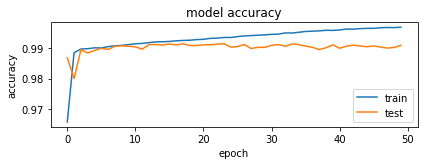

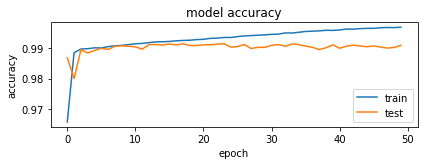

In [52]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()

fig